In [4]:
import sys
sys.argv = ['']
from functools import reduce
import numpy as np
import pandas as pd
import argparse
import torch
import os
import datetime
import time
from random import uniform
from math import sqrt
from torch import nn
import csv
import json
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import matplotlib

Below is the code for training a calssifier nueral netwrok with GEG, regarding the Robust oprimisation example.

In [50]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


def save_dictionary_to_file(filename, dictionary):
    with open(filename, 'w') as file:
        json.dump(dictionary, file, cls=NpEncoder)


def save_dictionary_settings(filename, dictionary):
    for k, v in dictionary.items():
        if isinstance(v, np.int64):
            dictionary[k] = int(v)

    with open(filename, "w") as myfile:
        json.dump(dictionary, myfile)


def write_list_of_lists(filename, lists):
    with open(filename, "w") as f:
        writer = csv.writer(f)
        writer.writerows(lists)


def clear_file(file):
    with open(file, "w") as _:
        pass


def append_file(msg, file):
    with open(file, "a") as f:
        f.write(msg + '\n')

In [51]:
def get_total_parameters_for_layer(param):
    return reduce(lambda x, y: x * y, np.array(param.detach().shape))


def get_total_number_of_parameters(parameters):
    total_number_of_parameters = 0

    for param in parameters:
        if param.requires_grad:
            total_number_of_parameters += get_total_parameters_for_layer(param)

    return total_number_of_parameters


def add_to_parameters(parameters, random_direction):
    pos = 0

    for param in parameters:
        if param.requires_grad:
            total_parameters_for_layer = get_total_parameters_for_layer(param)
            param.data = param.detach() + random_direction[pos:pos + total_parameters_for_layer].view(param.shape)
            pos += total_parameters_for_layer

In [52]:
class Model(torch.nn.Module):

    def __init__(self, num_features, num_samples, regularization_lambda, device, hidden_size=50):
        super(Model, self).__init__()
        # self.p = torch.rand(num_samples, requires_grad=True, dtype=torch.float32, device=device)
        self.p = torch.tensor([1 / num_samples] * num_samples, requires_grad=True, dtype=torch.float32, device=device)
        self.regularization_lambda = regularization_lambda
        self.num_samples = num_samples

        self.hidden = nn.Linear(num_features, hidden_size)
        self.hidden_act = nn.LeakyReLU(negative_slope=0.1)
        self.out = nn.Linear(hidden_size, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden(x)
        x = self.hidden_act(x)
        x = self.out(x)
        x = self.out_act(x)
        return x


def initialize_model(model, device, seed=42, divider=20):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_parameters_for_layer = get_total_parameters_for_layer(param)
            if len(param.shape) == 1:  # bias
                param.data = torch.zeros(param.shape, requires_grad=True, dtype=torch.float32, device=device).data
            else:
                param.data = ((torch.rand(total_parameters_for_layer, requires_grad=True, dtype=torch.float32,
                                          device=device) - 0.5) / divider).reshape(param.shape).data

In [53]:
EPS = 1e-12


def bce_loss(model, predictions, classes):
    """ Weighted cross entropy loss """
    loss = -((predictions + EPS).log() * classes + (1 - predictions + EPS).log() * (1 - classes))
    return torch.mean(loss.view(-1) * model.p)


def robustness_loss(model):
    return - model.regularization_lambda * torch.sum((model.p - 1 / model.num_samples) ** 2)


def total_loss(model, features, classes):
    predictions = model(features)
    return bce_loss(model, predictions, classes) + robustness_loss(model)

In [54]:
class ConvergedException(Exception):
    pass


def sample_gaussian_distribution(d,device):
    v = np.random.normal(0,1, size=d) 
    return torch.tensor(v, device=device, dtype=torch.float32)


class GTTEG:

    def __init__(self, parameters,eta=1e-6, gamma=0.1, device='cpu'):

        self.parameters = list(parameters)
        self.num_parameters = get_total_number_of_parameters(self.parameters)
        self.device = device

        self.ssize1 = eta
        self.ssize2 = gamma*eta


    def step(self, loss_function, *args):
        # Zero out any existing gradients
        for param in self.parameters:
            if param.requires_grad:
                param.grad = None  # Reset gradients to None

        # Compute the loss at the current parameters
        previous_loss = loss_function(*args)

        # Compute the gradient at the current parameters
        previous_loss.backward()  # Compute gradients

        # Get the gradient at the current parameters
        grad = torch.cat([param.grad.view(-1) for param in self.parameters if param.requires_grad])

        # Update parameters to get intermediate point
        add_to_parameters(self.parameters, -self.ssize1 * grad)

        # Zero out gradients again before computing the gradient at the intermediate point
        for param in self.parameters:
            if param.requires_grad:
                param.grad = None  # Reset gradients to None

        # Compute the loss at the intermediate point
        intermediate_loss = loss_function(*args)

        # Compute the gradient at the intermediate point
        intermediate_loss.backward()

        # Get the gradient at the intermediate point
        grad2 = torch.cat([param.grad.view(-1) for param in self.parameters if param.requires_grad])

        # Reset parameters to the original point
        add_to_parameters(self.parameters, self.ssize1 * grad)

        # Update parameters using the gradient at the intermediate point
        add_to_parameters(self.parameters, -self.ssize2 * grad2)

        # Compute the new loss
        new_loss = loss_function(*args)

        return new_loss.cpu().item(), grad2


In [55]:
def get_accuracy(predictions, classes):
    predictions = (predictions > 0.5).view(-1).detach().cpu().numpy().astype(int)
    acc=accuracy_score(classes, predictions)
    return acc

def accuracy_for_class(predictions, classes, class_value):
    # Filter true and predicted labels for the specified class
    predictions = (predictions > 0.5).view(-1).detach().cpu().numpy().astype(int)
    true_class = [classes[i] for i in range(len(classes)) if classes[i] == class_value]
    pred_class = [predictions[i] for i in range(len(predictions)) if classes[i] == class_value]

    # Calculate accuracy for the specified class
    correct_predictions = sum(1 for true, pred in zip(true_class, pred_class) if true == pred)
    total_samples = len(true_class)

    if total_samples == 0:
        return 0.0  # Avoid division by zero

    accuracy = correct_predictions / total_samples
    return accuracy

def run_robust():
    # Read data
    data = pd.read_csv(args.data_file, header=None)

    classes, features = np.array([[0] if val == 'M' else [1] for val in data.loc[:, 1].values],
                                 dtype=int), data.loc[:, 2:].values
    features_tensor = torch.tensor(features, dtype=torch.float32, requires_grad=False).to(args.device)
    classes_tensor = torch.tensor(classes, dtype=torch.float32, requires_grad=False).to(args.device)


    
    Test_acc = np.zeros((args.num_epochs,args.num_folds))
    Train_acc = np.zeros((args.num_epochs,args.num_folds))
    Test_acc0 = np.zeros((args.num_epochs,args.num_folds))
    Train_acc0 = np.zeros((args.num_epochs,args.num_folds))
    Test_acc1 = np.zeros((args.num_epochs,args.num_folds))
    Train_acc1 = np.zeros((args.num_epochs,args.num_folds))
    grad_x = np.zeros((args.num_epochs,args.num_folds))
    grad_y = np.zeros((args.num_epochs,args.num_folds))

    j=0
    kf = KFold(n_splits=args.num_folds, random_state=27, shuffle=True)
    kf.get_n_splits(features_tensor)
    ntime = []
    for train_index, test_index in kf.split(features_tensor):
        start = time.time()
        x_train, x_test = features_tensor[train_index], features_tensor[test_index]
        y_train, y_test = classes_tensor[train_index], classes_tensor[test_index]

        # Create model
        model = Model(x_train.shape[1], x_train.shape[0], args.reg_parameter, args.device, hidden_size=args.hidden_size)
        model.to(args.device)
        initialize_model(model, args.device, seed=42)

        GTTEG_max = GTTEG([model.p], eta = args.h_x, gamma=args.gamma, device=args.device)
        GTTEG_min = GTTEG(model.parameters(), eta = args.h_y, gamma=args.gamma, device=args.device)

        # minimize the negative as the maximization target
        negative_total_loss = lambda *x: - total_loss(*x)

        for epoch in range(args.num_epochs):

            try:
                 loss_d,g_y = GTTEG_max.step(negative_total_loss, model, x_train, y_train)
            except ConvergedException:
                pass

            try:
                loss_g,g_x = GTTEG_min.step(total_loss, model, x_train, y_train)
            except ConvergedException:
                pass

            predictions = model(x_train)
            Train_acc[epoch,j] = get_accuracy(predictions, y_train.numpy())
            Train_acc0[epoch,j] = accuracy_for_class(predictions, y_train.numpy(),class_value=0)
            Train_acc1[epoch,j] = accuracy_for_class(predictions, y_train.numpy(),class_value=1)

            predictions = model(x_test)
            Test_acc[epoch,j] = get_accuracy(predictions, y_test.numpy())
            Test_acc0[epoch,j] = accuracy_for_class(predictions, y_test.numpy(),class_value=0)
            Test_acc1[epoch,j] = accuracy_for_class(predictions, y_test.numpy(),class_value=1)
            # print(np.linalg.norm(np.array(g_x)))
            grad_x[epoch,j] = np.linalg.norm(np.array(g_x))
            grad_y[epoch,j] = np.linalg.norm(np.array(g_y))
            # print(np.array(g_x).shape)

        j = j+1
        end = time.time()
        ntime.append(end-start)
    return Train_acc,Train_acc0,Train_acc1,Test_acc,Test_acc0,Test_acc1,np.array(ntime), np.array(grad_x),np.array(grad_y)



In [ ]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_file", type=str, default='wdbc.data')
    parser.add_argument("--hidden_size", type=int, default=50, help="Hidden size of the MLP")
    parser.add_argument("--num_folds", type=int, default=5)
    parser.add_argument("--device", type=str, default="cpu")

    ts = time.time()
    curr_datetime = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    folder = 'robust_results_' + curr_datetime + '/'
    parser.add_argument("--save_results_folder", type=str, default=folder)
    parser.add_argument("--save_results_file", type=str, default="results.txt")

    parser.add_argument("--gamma", type=float, default=0.8)
    parser.add_argument("--h_x", type=float, default=5e-3)
    parser.add_argument("--h_y", type=float, default=1e-2)

    parser.add_argument("--reg_parameter", type=float, default=1,
                        help="Regularization parameter for the robust optimization problem")
    parser.add_argument("--num_epochs", type=int, default=30000)
    parser.add_argument("--verbose", type=int, default=1)
    args = parser.parse_args()

    Train_acc,Train_acc0,Train_acc1,Test_acc,Test_acc0,Test_acc1,ntime,grad_x,grad_y=run_robust()

Saving the reults for later use.

In [ ]:
# np.save('Train_acc.npy', Train_acc)
# np.save('Train_acc0.npy', Train_acc0)
# np.save('Train_acc1.npy', Train_acc1)
# np.save('Test_acc.npy', Test_acc)
# np.save('Test_acc0.npy', Test_acc0)
# np.save('Test_acc1.npy', Test_acc1)
# np.save('ntime.npy', np.array(ntime))
# np.save('grad_x.npy', grad_x)
# np.save('grad_y.npy', grad_y)

In [ ]:
# Train_acc = np.load('Train_acc.npy')
# Train_acc0 = np.load('Train_acc0.npy')
# Train_acc1 = np.load('Train_acc1.npy')
# Test_acc = np.load('Test_acc.npy')
# Test_acc0 = np.load('Test_acc0.npy')
# Test_acc1 = np.load('Test_acc1.npy')
# ntime = np.load('ntime.npy')
# grad_x = np.load('grad_x.npy')
# grad_y = np.load('grad_y.npy')

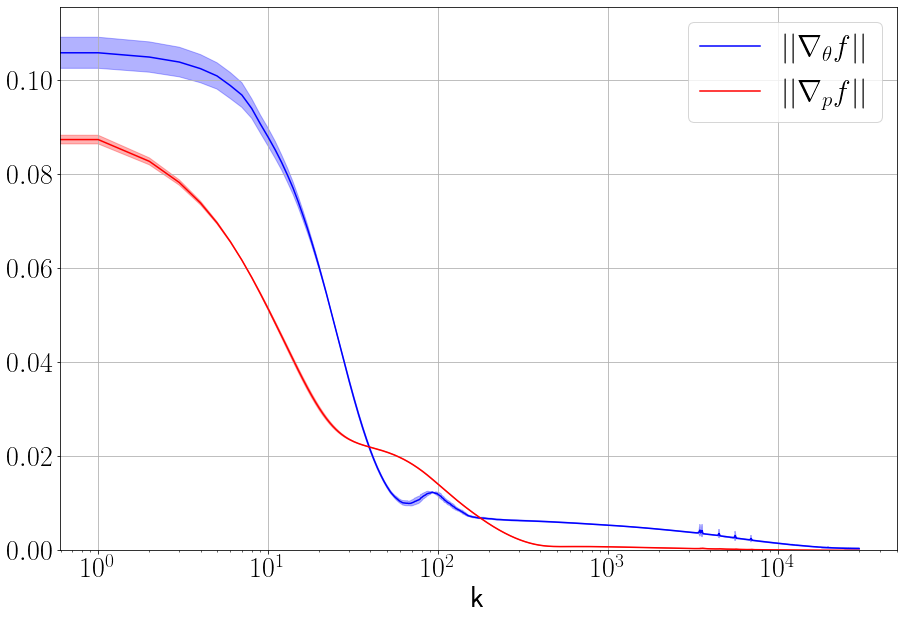

In [6]:
mean_gx = np.mean(grad_x, axis=1)
std_gx = np.std(grad_x, axis=1)
mean_gy = np.mean(grad_y, axis=1)
std_gy = np.std(grad_y, axis=1)
t = np.array(range(len(mean_gx)))
font = {'family': 'serif', 'weight': 'normal', 'size': 30}
font1 = {'family': 'serif', 'size': 30}

matplotlib.rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
matplotlib.rcParams['ps.fonttype'] = 42  # Use TrueType fonts for EPS
matplotlib.rcParams['text.usetex'] = True

plt.figure(figsize=(15,10))
plt.xticks(fontname='serif', fontsize=28, color='black')
plt.yticks(fontname='serif', fontsize=28, color='black')


plt.plot(t,mean_gx, label=r'$||\nabla_\theta f||$',color='blue')
plt.fill_between(t,
                 mean_gx - std_gx,
                 mean_gx + std_gx,
                 alpha=0.3,color='blue')


plt.plot(t,mean_gy, label=r'$||\nabla_p f||$',color='red')
plt.fill_between(t,
                 mean_gy - std_gy,
                 mean_gy + std_gy,
                 alpha=0.3,color='red')

plt.xscale('log')
plt.xlabel('k',fontdict=font)
# plt.ylabel('Gradient norms',fontdict=font)
plt.ylim(0,)
plt.grid('on')
plt.legend(loc='best', prop=font1)
plt.savefig('grad.pdf', format='pdf')


In [ ]:
print((mean_gx[-1]**2+mean_gy[-1]**2)**0.5)

0.00039424446838591374


Calculating the mean and standard deviation and plot them vs iterations and time for the accuracy of RMM and DS.

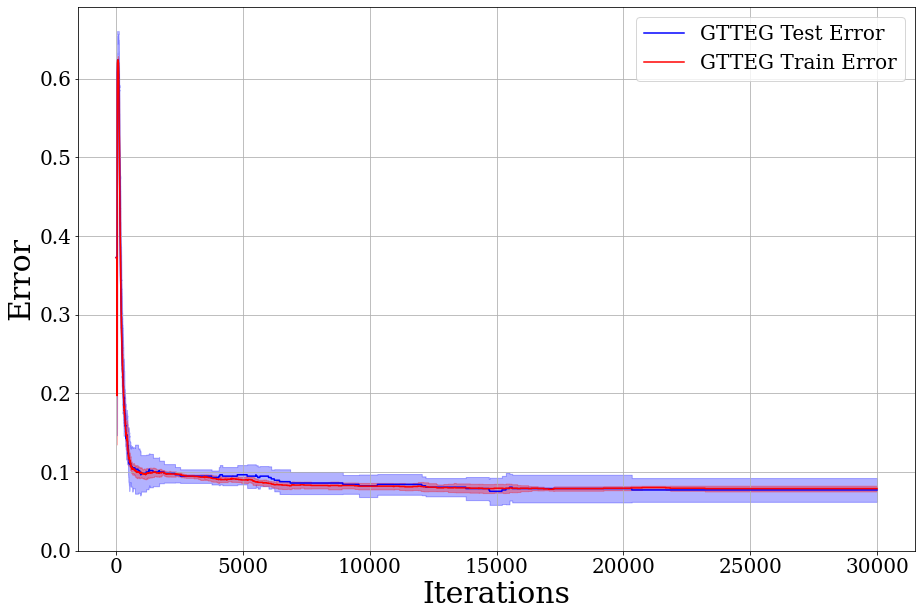

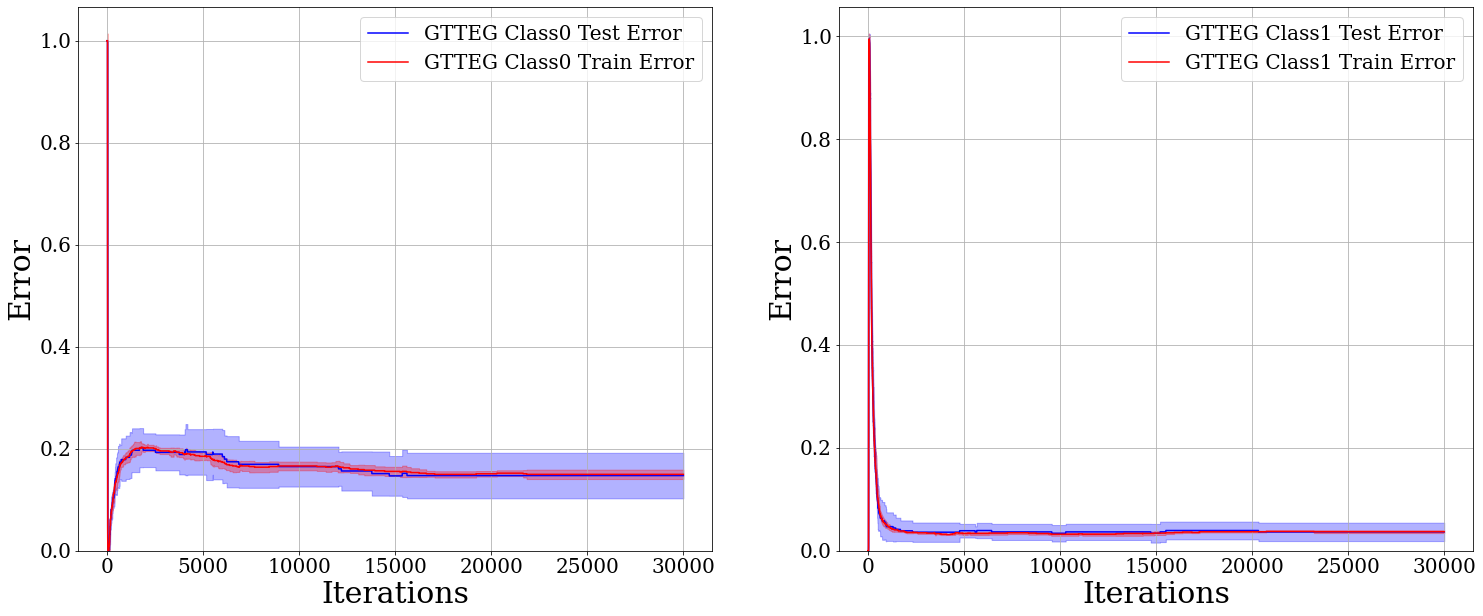

In [ ]:
Train_error = 1-Train_acc
Train_error0 = 1-Train_acc0
Train_error1 = 1-Train_acc1
Test_error = 1-Test_acc
Test_error0 = 1-Test_acc0
Test_error1 = 1-Test_acc1

# Calculate mean and standard deviation along axis 1 (across runs)
mean_accuracy_test = np.mean(Test_error, axis=1)
std_dev_accuracy_test = np.std(Test_error, axis=1)
mean_accuracy_test0 = np.mean(Test_error0, axis=1)
std_dev_accuracy_test0 = np.std(Test_error0, axis=1)
mean_accuracy_test1 = np.mean(Test_error1, axis=1)
std_dev_accuracy_test1 = np.std(Test_error1, axis=1)

mean_accuracy_train = np.mean(Train_error, axis=1)
std_dev_accuracy_train = np.std(Train_error, axis=1)
mean_accuracy_train0 = np.mean(Train_error0, axis=1)
std_dev_accuracy_train0 = np.std(Train_error0, axis=1)
mean_accuracy_train1 = np.mean(Train_error1, axis=1)
std_dev_accuracy_train1 = np.std(Train_error1, axis=1)


t = np.array(range(len(mean_accuracy_test)))

font = {'family': 'serif', 'weight': 'normal', 'size': 30}
font1 = {'family': 'serif', 'size': 20}
plt.figure(figsize=(15,10))
plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')


plt.plot(t,mean_accuracy_test, label='GTTEG Test Error',color='blue')
plt.fill_between(t,
                 mean_accuracy_test - std_dev_accuracy_test,
                 mean_accuracy_test + std_dev_accuracy_test,
                 alpha=0.3,color='blue')


plt.plot(t,mean_accuracy_train, label='GTTEG Train Error',color='red')
plt.fill_between(t,
                 mean_accuracy_train - std_dev_accuracy_train,
                 mean_accuracy_train + std_dev_accuracy_train,
                 alpha=0.3,color='red')


plt.xlabel('Iterations',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.ylim(0,)
plt.grid('on')
# plt.xlim(0,22001)
plt.legend(loc='best', prop=font1)
# plt.savefig('Both.pdf', format='pdf')
plt.show()

plt.figure(figsize=(25,10))

plt.subplot(1,2,1)
plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')

plt.plot(t,mean_accuracy_test0, label='GTTEG Class0 Test Error',color='blue')

plt.fill_between(t,
                 mean_accuracy_test0 - std_dev_accuracy_test0,
                 mean_accuracy_test0 + std_dev_accuracy_test0,
                 alpha=0.3,color='blue')



plt.plot(t,mean_accuracy_train0, label='GTTEG Class0 Train Error',color='red')

plt.fill_between(t,
                 mean_accuracy_train0 - std_dev_accuracy_train0,
                 mean_accuracy_train0 + std_dev_accuracy_train0,
                 alpha=0.3,color='red')



plt.xlabel('Iterations',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.ylim(0,)
plt.grid('on')
# plt.xlim(0,22001)
plt.legend(loc='best', prop=font1)

plt.subplot(1, 2, 2)

plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')

plt.plot(t,mean_accuracy_test1, label='GTTEG Class1 Test Error',color='blue')
plt.fill_between(t,
                 mean_accuracy_test1 - std_dev_accuracy_test1,
                 mean_accuracy_test1 + std_dev_accuracy_test1,
                 alpha=0.3,color='blue')


plt.plot(t,mean_accuracy_train1, label='GTTEG Class1 Train Error',color='red')
plt.fill_between(t,
                 mean_accuracy_train1 - std_dev_accuracy_train1,
                 mean_accuracy_train1 + std_dev_accuracy_train1,
                 alpha=0.3,color='red')


plt.xlabel('Iterations',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.ylim(0,)
plt.grid('on')
# plt.xlim(0,22001)
plt.legend(loc='upper right', prop=font1)
# plt.savefig('class10.pdf', format='pdf')
plt.show()

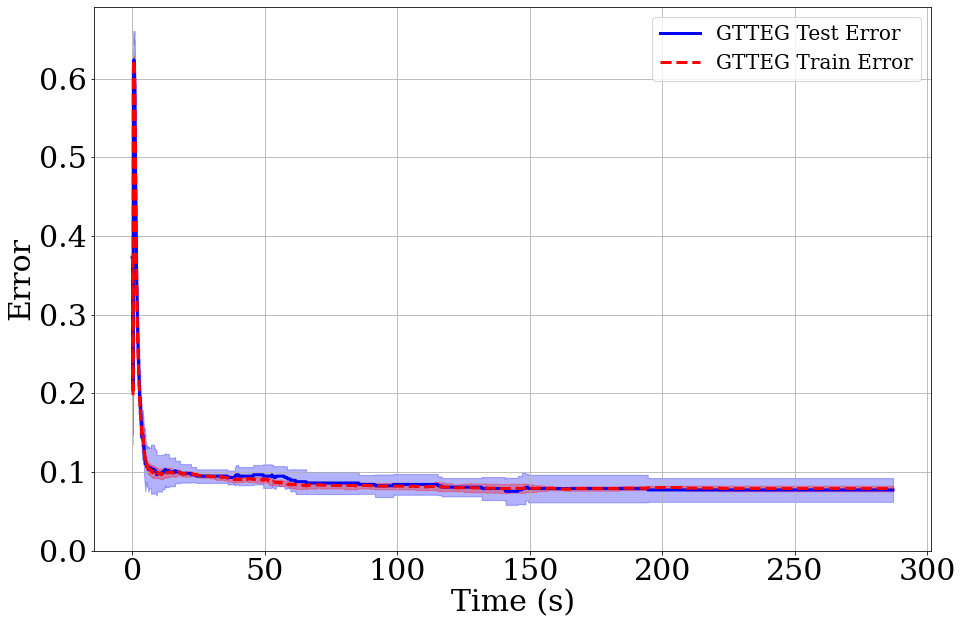

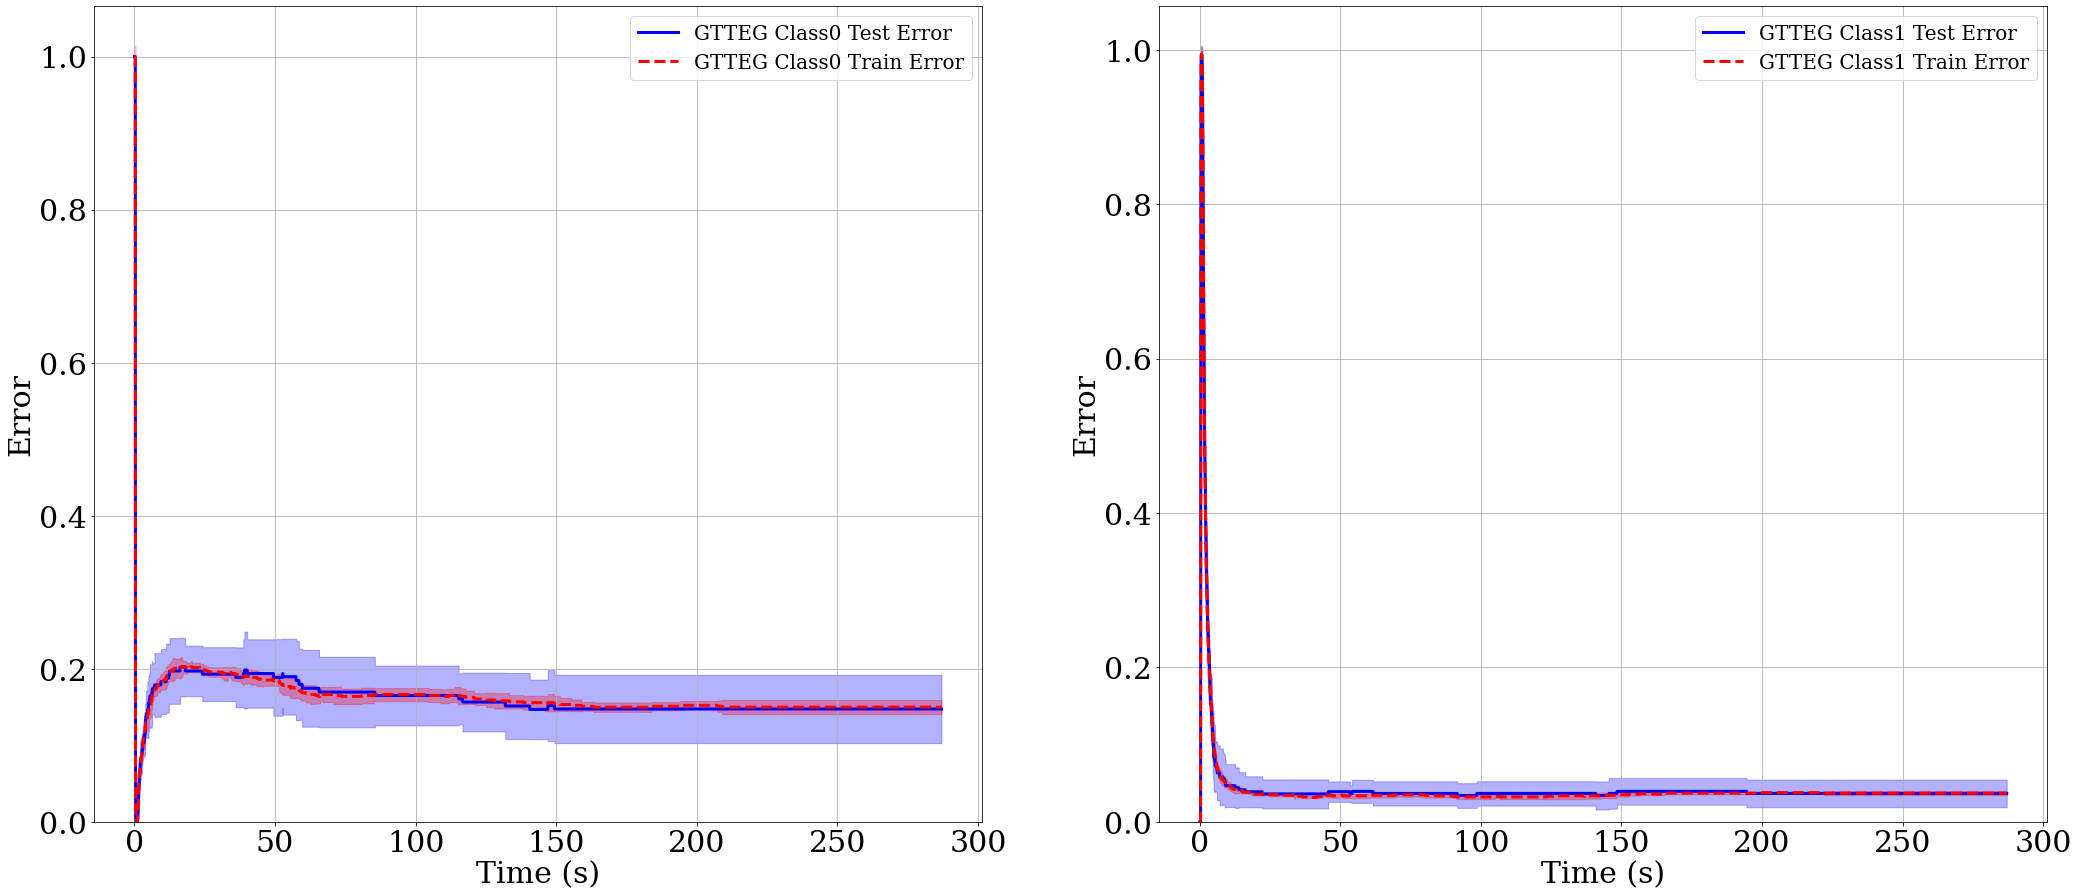

In [ ]:
ntime_avg = np.mean(ntime)
t = np.linspace(0,int(ntime_avg),len(mean_accuracy_test))

font = {'family': 'serif', 'weight': 'normal', 'size': 30}
font1 = {'family': 'serif', 'size': 20}
plt.figure(figsize=(15,10))
plt.xticks(fontname='serif', fontsize=30, color='black')
plt.yticks(fontname='serif', fontsize=30, color='black')


plt.plot(t,mean_accuracy_test,'-', label='GTTEG Test Error',color='blue',linewidth=3)
plt.fill_between(t,
                 mean_accuracy_test - std_dev_accuracy_test,
                 mean_accuracy_test + std_dev_accuracy_test,
                 alpha=0.3,color='blue')


plt.plot(t,mean_accuracy_train,'--', label='GTTEG Train Error',color='red',linewidth=3)
plt.fill_between(t,
                 mean_accuracy_train - std_dev_accuracy_train,
                 mean_accuracy_train + std_dev_accuracy_train,
                 alpha=0.3,color='red')


plt.xlabel('Time (s)',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.grid('on')
plt.ylim(0,)
plt.legend(loc='best', prop=font1)
# plt.savefig('Both_time.pdf', format='pdf',bbox_inches='tight')
plt.show()

plt.figure(figsize=(35,15))

plt.subplot(1,2,1)
plt.xticks(fontname='serif', fontsize=30, color='black')
plt.yticks(fontname='serif', fontsize=30, color='black')

plt.plot(t,mean_accuracy_test0,'-', label='GTTEG Class0 Test Error',color='blue',linewidth=3)

plt.fill_between(t,
                 mean_accuracy_test0 - std_dev_accuracy_test0,
                 mean_accuracy_test0 + std_dev_accuracy_test0,
                 alpha=0.3,color='blue')


plt.plot(t,mean_accuracy_train0,'--', label='GTTEG Class0 Train Error',color='red',linewidth=3)

plt.fill_between(t,
                 mean_accuracy_train0 - std_dev_accuracy_train0,
                 mean_accuracy_train0 + std_dev_accuracy_train0,
                 alpha=0.3,color='red')


plt.xlabel('Time (s)',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.ylim(0,)
plt.grid('on')
plt.legend(loc='best', prop=font1)

plt.subplot(1, 2, 2)

plt.xticks(fontname='serif', fontsize=30, color='black')
plt.yticks(fontname='serif', fontsize=30, color='black')

plt.plot(t,mean_accuracy_test1,'-', label='GTTEG Class1 Test Error',color='blue',linewidth=3)
plt.fill_between(t,
                 mean_accuracy_test1 - std_dev_accuracy_test1,
                 mean_accuracy_test1 + std_dev_accuracy_test1,
                 alpha=0.3,color='blue')

plt.plot(t,mean_accuracy_train1,'--', label='GTTEG Class1 Train Error',color='red',linewidth=3)
plt.fill_between(t,
                 mean_accuracy_train1 - std_dev_accuracy_train1,
                 mean_accuracy_train1 + std_dev_accuracy_train1,
                 alpha=0.3,color='red')

plt.xlabel('Time (s)',fontdict=font)
plt.ylabel('Error',fontdict=font)
plt.ylim(0,)
plt.grid('on')
plt.legend(loc='upper right', prop=font1)
# plt.savefig('class10_time.pdf', format='pdf',bbox_inches='tight')
plt.show()

The Below section is to calculate Hessian at the limit points and analyse limit points to see whether they are saddle points or not.

In [62]:
def compute_hessian(loss_function, parameters, *args):
    first_order_grads = torch.autograd.grad(loss_function(*args), parameters, create_graph=True)
    
    # Flatten the gradients into a single vector
    grads = torch.cat([g.view(-1) for g in first_order_grads])
    
    # Compute the second-order gradients (Hessian)
    hessian = []
    for grad in grads:
        second_order_grads = torch.autograd.grad(grad, parameters, retain_graph=True)
        second_order_grads = torch.cat([g.view(-1) for g in second_order_grads])
        hessian.append(second_order_grads)
    
    # Stack the second-order gradients into a Hessian matrix
    hessian = torch.stack(hessian)
    return hessian

def is_positive_definite(matrix):
    eigenvalues = torch.linalg.eigvalsh(matrix)
    num_negative = torch.sum(eigenvalues < 0).item()
    num_positive = torch.sum(eigenvalues > 0).item()
    print('should be psd',torch.min(eigenvalues),torch.max(eigenvalues))
    return torch.all(eigenvalues > 0)

def is_negative_definite(matrix):
    eigenvalues = torch.linalg.eigvalsh(matrix)
    num_negative = torch.sum(eigenvalues < 0).item()
    num_positive = torch.sum(eigenvalues > 0).item()
    print('should be nsd',torch.min(eigenvalues),torch.max(eigenvalues))
    return torch.all(eigenvalues < 0)

In [63]:
data = pd.read_csv(args.data_file, header=None)

classes, features = np.array([[0] if val == 'M' else [1] for val in data.loc[:, 1].values],
                             dtype=int), data.loc[:, 2:].values
features_tensor = torch.tensor(features, dtype=torch.float32, requires_grad=False).to(args.device)
classes_tensor = torch.tensor(classes, dtype=torch.float32, requires_grad=False).to(args.device)


train_size = int(0.7 * len(features_tensor)) 
train_index = np.random.choice(len(features_tensor), train_size, replace=False)
test_index = np.setdiff1d(np.arange(len(features_tensor)), train_index)

x_train, x_test = features_tensor[train_index], features_tensor[test_index]
y_train, y_test = classes_tensor[train_index], classes_tensor[test_index]



In [ ]:
num_epoch = 50000
Test_acc = np.zeros((num_epoch, 1))
Train_acc = np.zeros((num_epoch, 1))

grad_x = np.zeros((num_epoch, 1))    
grad_y = np.zeros((num_epoch, 1))

start = time.time()

# Create model
model = Model(x_train.shape[1], x_train.shape[0], args.reg_parameter, args.device, hidden_size=args.hidden_size)
model.to(args.device)
initialize_model(model, args.device, seed=42)
GTTEG_max = GTTEG([model.p], eta=args.h_x, gamma=args.gamma, device=args.device)
GTTEG_min = GTTEG(model.parameters(), eta=args.h_y, gamma=args.gamma, device=args.device)

# Minimize the negative as the maximization target
negative_total_loss = lambda *x: -total_loss(*x)

for epoch in range(num_epoch):
    try:
        loss_d, g_y = GTTEG_max.step(negative_total_loss, model, x_train, y_train)
    except ConvergedException:
        pass

    try:
        loss_g, g_x = GTTEG_min.step(total_loss, model, x_train, y_train)
    except ConvergedException:
        pass

    predictions = model(x_train)
    Train_acc[epoch, 0] = get_accuracy(predictions, y_train.numpy())

    predictions = model(x_test)
    Test_acc[epoch, 0] = get_accuracy(predictions, y_test.numpy())
    
    grad_x[epoch, 0] = np.linalg.norm(np.array(g_x))
    grad_y[epoch, 0] = np.linalg.norm(np.array(g_y))

end = time.time()
time_taken = end - start

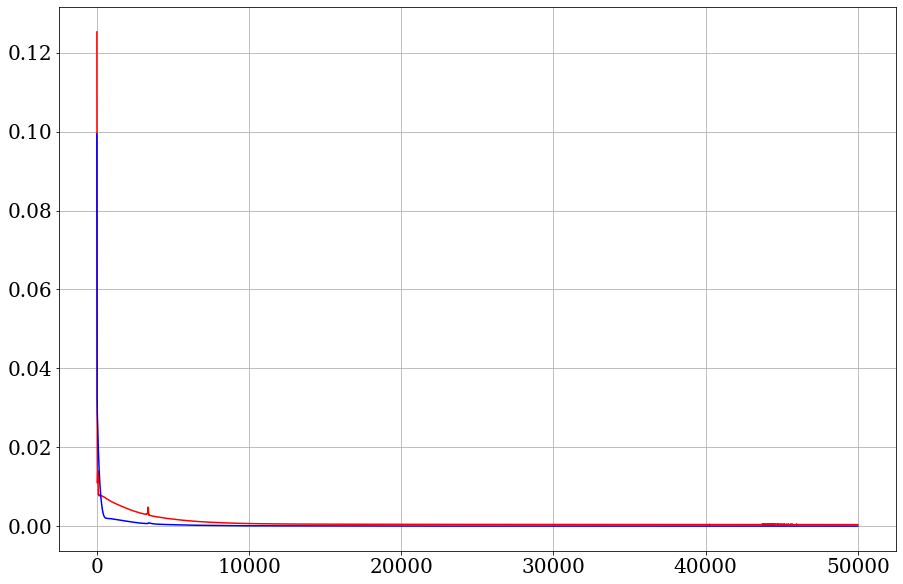

In [ ]:
t = np.array(range(len(grad_x)))

font = {'family': 'serif', 'weight': 'normal', 'size': 30}
font1 = {'family': 'serif', 'size': 20}
plt.figure(figsize=(15,10))
plt.xticks(fontname='serif', fontsize=20, color='black')
plt.yticks(fontname='serif', fontsize=20, color='black')


plt.plot(t,grad_x, label='grad_x',color='red')
plt.plot(t,grad_y, label='grad_y',color='blue')
plt.grid('on')

In [ ]:
print(grad_x[-1],grad_y[-1])

[0.00039331] [1.68996885e-05]


In [ ]:
hessian_xx = compute_hessian(total_loss, list(model.parameters()),model, x_train, y_train)
hessian_yy = compute_hessian(total_loss, [model.p], model, x_train, y_train)

In [ ]:
print(is_positive_definite(hessian_xx),is_negative_definite(hessian_yy))

should be pd tensor(-0.0012) tensor(31.5728) Number of negative eigenvalues: 772 Number of positive eigenvalues: 829
should be pd tensor(-1.) tensor(-1.) Number of negative eigenvalues: 398 Number of positive eigenvalues: 0
tensor(False) tensor(True)


The below code is to check Hessian at the limit points for different initial values.

In [73]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("--data_file", type=str, default='wdbc.data')
    parser.add_argument("--hidden_size", type=int, default=50, help="Hidden size of the MLP")
    parser.add_argument("--num_folds", type=int, default=2)
    parser.add_argument("--device", type=str, default="cpu")

    ts = time.time()
    curr_datetime = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d-%H-%M-%S')
    folder = 'robust_results_' + curr_datetime + '/'
    parser.add_argument("--save_results_folder", type=str, default=folder)
    parser.add_argument("--save_results_file", type=str, default="results.txt")

    parser.add_argument("--gamma", type=float, default=0.8)
    parser.add_argument("--h_x", type=float, default=1e-2)
    parser.add_argument("--h_y", type=float, default=2e-2)

    parser.add_argument("--reg_parameter", type=float, default=5,
                        help="Regularization parameter for the robust optimization problem")
    parser.add_argument("--num_epochs", type=int, default=100000)
    parser.add_argument("--verbose", type=int, default=1)
    args = parser.parse_args()

In [74]:
num_seeds = 5  # Change this to how many different seeds you want


all_grad_x = []
all_grad_y = []
all_time_taken = []
all_initial_params = []
all_final_params = []

for i in range(num_seeds):
    seed = 42 + i*3  # Different seed for each run

    grad_x = np.zeros((args.num_epochs, 1))    
    grad_y = np.zeros((args.num_epochs, 1))


    # Create model
    model = Model(x_train.shape[1], x_train.shape[0], args.reg_parameter, args.device, hidden_size=args.hidden_size)
    model.to(args.device)
    initialize_model(model, args.device, seed=seed)

    initial_params = np.concatenate([param.clone().detach().cpu().numpy().flatten() for param in model.parameters()])
    all_initial_params.append(initial_params)


    GTTEG_max = GTTEG([model.p], eta=args.h_x, gamma=args.gamma, device=args.device)
    GTTEG_min = GTTEG(model.parameters(), eta=args.h_y, gamma=args.gamma, device=args.device)

    # Minimize the negative as the maximization target
    negative_total_loss = lambda *x: -total_loss(*x)

    for epoch in range(args.num_epochs):
        try:
            loss_d, g_y = GTTEG_max.step(negative_total_loss, model, x_train, y_train)
        except ConvergedException:
            pass

        try:
            loss_g, g_x = GTTEG_min.step(total_loss, model, x_train, y_train)
        except ConvergedException:
            pass

        grad_x[epoch, 0] = np.linalg.norm(np.array(g_x))
        grad_y[epoch, 0] = np.linalg.norm(np.array(g_y))

    hessian_xx = compute_hessian(total_loss, list(model.parameters()), model, x_train, y_train)
    hessian_yy = compute_hessian(total_loss, [model.p], model, x_train, y_train)

    print(f"Seed {seed}: ", is_positive_definite(hessian_xx), is_negative_definite(hessian_yy))
    print("grad norm:", (grad_x[-1]**2+grad_y[-1]**2)**0.5)

    final_params = np.concatenate([param.clone().detach().cpu().numpy().flatten() for param in model.parameters()])
    all_final_params.append(final_params)

    all_grad_x.append(grad_x)
    all_grad_y.append(grad_y)

# Convert lists to arrays if needed
all_grad_x = np.array(all_grad_x)
all_grad_y = np.array(all_grad_y)
all_initial_params = np.array(all_initial_params, dtype=object)  # Use dtype=object to handle variable sizes
all_final_params = np.array(all_final_params, dtype=object)


should be psd tensor(-0.0055) tensor(30.3225)
should be nsd tensor(-10.) tensor(-10.)
Seed 42:  tensor(False) tensor(True)
grad norm: [0.00018037]
should be psd tensor(-0.0012) tensor(30.1497)
should be nsd tensor(-10.) tensor(-10.)
Seed 45:  tensor(False) tensor(True)
grad norm: [0.00030952]
should be psd tensor(-0.0006) tensor(30.5415)
should be nsd tensor(-10.) tensor(-10.)
Seed 48:  tensor(False) tensor(True)
grad norm: [0.00021829]
should be psd tensor(-0.0006) tensor(30.4445)
should be nsd tensor(-10.) tensor(-10.)
Seed 51:  tensor(False) tensor(True)
grad norm: [0.00019995]
should be psd tensor(-0.0006) tensor(29.9568)
should be nsd tensor(-10.) tensor(-10.)
Seed 54:  tensor(False) tensor(True)
grad norm: [0.00018301]


In [79]:
print(np.linalg.norm(all_initial_params[2,:]-all_initial_params[3,:]),np.linalg.norm(all_final_params[2,:]-all_final_params[3,:]),np.linalg.norm(all_initial_params[2,:]),np.linalg.norm(all_final_params[2,:]),np.linalg.norm(all_initial_params[3,:]),np.linalg.norm(all_final_params[3,:]))

0.7987926978073726 1.2372104755963724 0.5641886515251453 0.8683771907299225 0.5650669441075065 0.8469548287329374


In [76]:
# np.save('all_grad_x.npy', all_grad_x)
# np.save('all_grad_y.npy', all_grad_y)
# all_grad_x = np.load('all_grad_x.npy')
# all_grad_y = np.load('all_grad_y.npy')

Text(0.5, 1.0, 'Initial value 5')

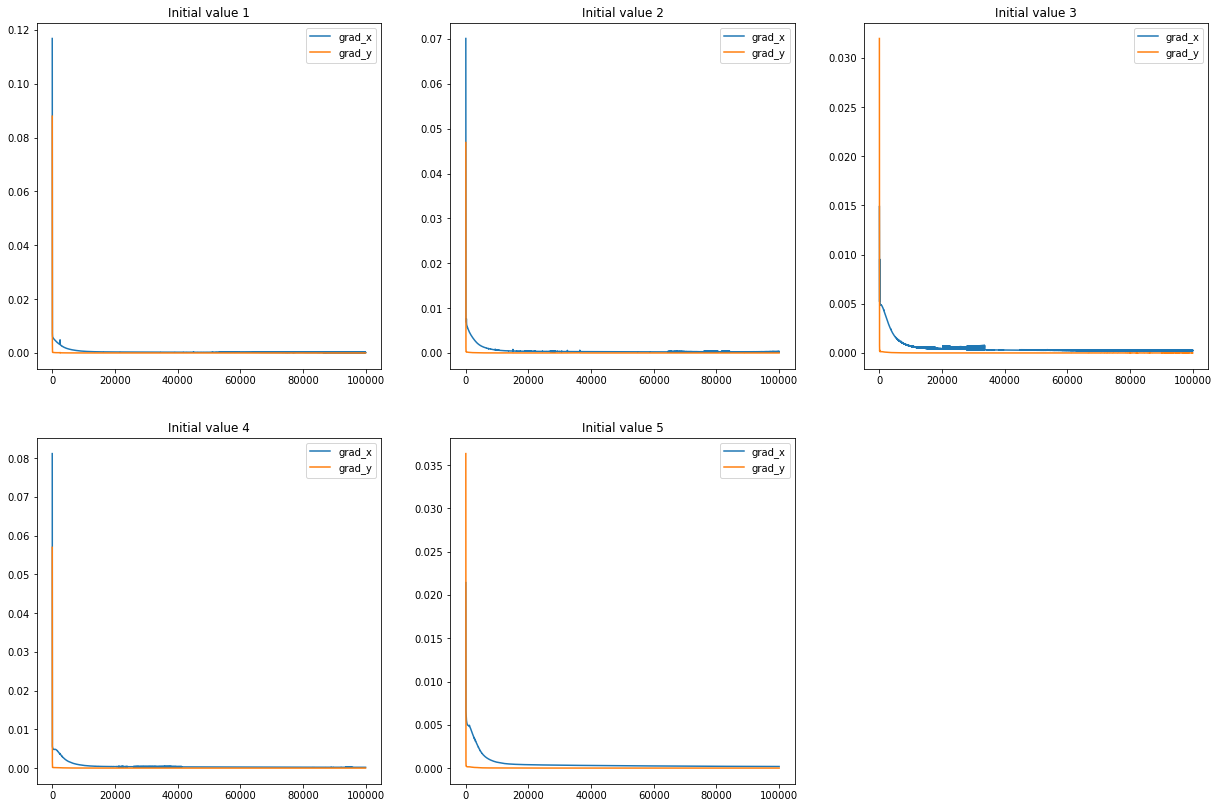

In [77]:
plt.figure(figsize=(21,14))
plt.subplot(2,3,1)
plt.plot(all_grad_x[0,:],label='grad_x')
plt.plot(all_grad_y[0,:],label='grad_y')
plt.legend()
plt.title('Initial value 1')

plt.subplot(2,3,2)
plt.plot(all_grad_x[1,:],label='grad_x')
plt.plot(all_grad_y[1,:],label='grad_y')
plt.legend()
plt.title('Initial value 2')

plt.subplot(2,3,3)
plt.plot(all_grad_x[2,:],label='grad_x')
plt.plot(all_grad_y[2,:],label='grad_y')
plt.legend()
plt.title('Initial value 3')

plt.subplot(2,3,4)
plt.plot(all_grad_x[3,:],label='grad_x')
plt.plot(all_grad_y[3,:],label='grad_y')
plt.legend()
plt.title('Initial value 4')

plt.subplot(2,3,5)
plt.plot(all_grad_x[4,:],label='grad_x')
plt.plot(all_grad_y[4,:],label='grad_y')
plt.legend()
plt.title('Initial value 5')
